In [32]:
import numpy as np
import networkx as nx
import torch
from torch_geometric.data import Data
from ogb.lsc.pcqm4mv2_pyg import PygPCQM4Mv2Dataset
from functools import lru_cache


In [33]:
def counter_example_1_1(k, m):
    n = 2 * k * m + 1
    edge_index_1_1 = np.arange(2*k*m) + 1
    edge_index_1_2 = np.mod(edge_index_1_1, 2 * k * m) + 1
    edge_index_1 = np.concatenate((edge_index_1_1[None, :], edge_index_1_2[None, :]), axis=0)

    edge_index_2_1 = np.zeros(2*k*m, dtype=np.longlong) + n
    edge_index_2_mask = np.mod(edge_index_1_1, m) == 0
    edge_index_2 = np.concatenate((edge_index_2_1[edge_index_2_mask][None, :], edge_index_1_1[edge_index_2_mask][None, :]), axis=0)

    edge_index = np.concatenate((edge_index_1, edge_index_2), axis=1)

    G = nx.Graph()
    G.add_edges_from((edge_index - 1).T.tolist())
    return G

def counter_example_1_2(k, m):
    n = 2 * k * m + 1
    edge_index_1_1 = np.arange(k * m) + 1
    edge_index_1_2 = np.mod(edge_index_1_1, k * m) + 1
    edge_index_1 = np.concatenate((edge_index_1_1[None, :], edge_index_1_2[None, :]), axis=0)

    edge_index_2_1 = np.zeros(2 * k * m, dtype=np.longlong) + n
    edge_index_2_1_1 = np.arange(2*k*m) + 1
    edge_index_2_mask = np.mod(edge_index_2_1_1, m) == 0
    edge_index_2 = np.concatenate(
        (edge_index_2_1[edge_index_2_mask][None, :], edge_index_2_1_1[edge_index_2_mask][None, :]), axis=0)

    edge_index_3_1 = edge_index_1_1 + k * m
    edge_index_3_2 = np.mod(edge_index_1_1, k * m) + k * m + 1
    edge_index_3 = np.concatenate(
        (edge_index_3_1[None, :], edge_index_3_2[None, :]), axis=0
    )

    edge_index = np.concatenate((edge_index_1, edge_index_2, edge_index_3), axis=1)

    G = nx.Graph()
    G.add_edges_from((edge_index - 1).T.tolist())
    return G

def counter_example_2_1(m):
    n = 2 * m
    edge_index_1_1 = np.arange(2 * m) + 1
    edge_index_1_2 = np.mod(edge_index_1_1, n) + 1

    edge_index = np.concatenate((edge_index_1_1[None, :], edge_index_1_2[None, :]), axis=0)
    edge_index = np.concatenate((edge_index, np.array([m, 2*m], dtype=np.longlong)[:, None]), axis=1)

    G = nx.Graph()
    G.add_edges_from((edge_index - 1).T.tolist())
    return G

def counter_example_2_2(m):
    n = 2 * m
    edge_index_1_1 = np.arange(m) + 1
    edge_index_1_2 = np.mod(edge_index_1_1, m) + 1

    edge_index = np.concatenate((edge_index_1_1[None, :], edge_index_1_2[None, :]), axis=0)
    edge_index = np.concatenate((edge_index, np.array([m, 2 * m], dtype=np.longlong)[:, None]), axis=1)

    edge_index_3_1 = np.arange(m) + 1
    edge_index_3_2 = np.mod(edge_index_3_1, m) + m + 1
    edge_index_3 = np.concatenate(((edge_index_3_1+m)[None, :], edge_index_3_2[None, :]), axis=0)
    edge_index = np.concatenate((edge_index, edge_index_3), axis=1)

    G = nx.Graph()
    G.add_edges_from((edge_index - 1).T.tolist())
    return G

def counter_example_3_component(n, d, out_deg, base_index):
    node_degree_list = np.zeros(n, dtype=np.longlong)
    edge_index = []
    node_degree_list[:out_deg] = 1
    choose_list_i = np.argsort(node_degree_list)
    for i in choose_list_i:
        # np.random.shuffle(node_index_list)
        if node_degree_list[i] == d:
            continue
        choose_list_j = np.argsort(node_degree_list)
        for j in choose_list_j:
            if j == i:
                continue
            if node_degree_list[j] < d:
                edge_index.append((i + base_index, j + base_index))
                node_degree_list[j] += 1
                node_degree_list[i] += 1
            if node_degree_list[i] == d:
                break

    return edge_index

def counter_exmple_3():
    # (1) sample the number of connected components
    total_nodes = 40
    n_components = np.random.choice([2,3,4])
    # n_components = 4
    # np.random.seed(10)
    components_tree = nx.random_tree(n_components)
    components_tree_edge_list = list(components_tree.edges())
    components_tree_degree_list = list(components_tree.degree())

    avg_n_max = total_nodes // n_components
    avg_n_min_odd = 7
    avg_n_min_even = 6

    edge_index_list = []
    base_index = [0]
    all_d = np.random.choice([3])
    for i in range(n_components):
        cur_d = all_d
        cur_ed = components_tree_degree_list[i][1]

        if cur_ed % 2 == 1:
            cur_n = np.random.choice(np.arange(start=max(avg_n_min_odd, (cur_d+cur_ed+1)//2*2+1), stop=avg_n_max+2, step=2))
        else:
            cur_n = np.random.choice(np.arange(start=max(avg_n_min_even, ((cur_d+cur_ed+1)//2+1)*2), stop=avg_n_max+2, step=2))

        connect_flag = True
        while connect_flag:
            g_edge_index = counter_example_3_component(cur_n, cur_d, cur_ed, base_index[i])
            G = nx.Graph()
            G.add_edges_from(g_edge_index)
            if nx.is_connected(G):
                connect_flag = False
                edge_index_list.extend(g_edge_index)
                base_index.append(base_index[-1] + cur_n)

    # (2) connect components
    last_degree_list = np.ones(base_index[-1])
    for pair_i, pair_j in components_tree_edge_list:
        i_out_deg = components_tree_degree_list[pair_i][1]
        j_out_deg = components_tree_degree_list[pair_j][1]

        to_i = 0
        to_j = 0
        for i in range(i_out_deg):
            if last_degree_list[i+base_index[pair_i]] > 0:
                to_i = i+base_index[pair_i]
                last_degree_list[i+base_index[pair_i]] -= 1
                break
        for j in range(j_out_deg):
            if last_degree_list[j + base_index[pair_j]] > 0:
                to_j = j+base_index[pair_j]
                last_degree_list[j + base_index[pair_j]] -= 1
                break
        edge_index_list.append((to_i, to_j))

    G = nx.Graph()
    G.add_edges_from(edge_index_list)
    return G

In [34]:
def generate_cut_examples():
    func_dict = {
        0: counter_example_1_1,
        1: counter_example_1_2,
        2: counter_example_2_1,
        3: counter_example_2_2,
        4: counter_exmple_3,
    }

    index = int(np.random.choice(5, 1, p=[0.2,0.2,0.2,0.2,0.2]))
    if index == 4:
        return func_dict[index]()
    elif index > 1:
        m = int(np.random.choice(2) + 3)
        return func_dict[index](m)
    else:
        m = int(np.random.choice(2) + 3)
        k = int(np.random.choice(2) + 1)
        return func_dict[index](k, m)

In [35]:
def convert_graph_to_item(graph, item):
    new_item = Data()
    G_int = nx.convert_node_labels_to_integers(graph)
    G = G_int.to_directed() if not nx.is_directed(G_int) else G_int
    edge_index = torch.tensor(list(G.edges)).t().contiguous()

    new_item.edge_index = edge_index
    new_item.edge_attr = torch.zeros(new_item.edge_index.shape[1], 3).to(item.edge_attr)
    new_item.__num_nodes__ = G.number_of_nodes()
    new_item.idx = item.idx
    new_item.x = torch.ones(new_item.num_nodes, 9).to(item.x)
    new_item.y = item.y
    # new_item.resistance_distance = calculate_resistance_distance_online(G_int, new_item.num_nodes)
    # new_item.resistance_distance = torch.zeros(new_item.x.shape[0], 130)
    return new_item


In [36]:
@torch.jit.script
def convert_to_single_emb(x, offset: int = 512):
    feature_num = x.size(1) if len(x.size()) > 1 else 1
    feature_offset = 1 + torch.arange(0, feature_num * offset, offset, dtype=torch.long)
    x = x + feature_offset
    return x

In [79]:
def preprocess_item_bridge(item):
    new_graph = generate_cut_examples()
    item = convert_graph_to_item(new_graph, item)

    edge_attr, edge_index, x = item.edge_attr, item.edge_index, item.x
    # resistance_distance = item.resistance_distance
    N = x.size(0)
    x = convert_to_single_emb(x)

    # node adj matrix [N, N] bool
    adj = torch.zeros([N, N], dtype=torch.bool)
    adj[edge_index[0, :], edge_index[1, :]] = True

    # edge feature here
    if len(edge_attr.size()) == 1:
        edge_attr = edge_attr[:, None]
    attn_edge_type = torch.zeros([N, N, edge_attr.size(-1)], dtype=torch.long)
    attn_edge_type[edge_index[0, :], edge_index[1, :]] = (
        convert_to_single_emb(edge_attr) + 1
    )

    # shortest_path_result, path = algos.floyd_warshall(adj.numpy())
    # max_dist = np.amax(shortest_path_result)
    # edge_input = algos.gen_edge_input(max_dist, path, attn_edge_type.numpy())
    # spatial_pos = torch.from_numpy((shortest_path_result)).long()
    # res_pos = resistance_distance[:, :N]
    attn_bias = torch.zeros([N + 1, N + 1], dtype=torch.float)  # with graph token

    G = nx.from_numpy_array(adj.numpy())
    g_bridge_list = list(nx.bridges(G))
    bridge_label = torch.zeros([N, N], dtype=torch.long)
    bridge_label[edge_index[0, :], edge_index[1, :]] = -1
    if len(g_bridge_list) > 0:
        g_bridge_list = torch.Tensor(g_bridge_list).long()
        bridge_label[g_bridge_list[:, 0], g_bridge_list[:, 1]] = 1
        bridge_label[g_bridge_list[:, 1], g_bridge_list[:, 0]] = 1
    item.y = bridge_label

    # combine
    item.x = x
    item.attn_bias = attn_bias
    item.attn_edge_type = attn_edge_type
    # item.spatial_pos = spatial_pos
    # item.res_pos = res_pos
    item.in_degree = adj.long().sum(dim=1).view(-1)
    item.out_degree = item.in_degree  # for undirected graph
    # item.edge_input = torch.from_numpy(edge_input).long()

    return item

def preprocess_item_articulation_point(item):
    new_graph = generate_cut_examples()
    item = convert_graph_to_item(new_graph, item)

    edge_attr, edge_index, x = item.edge_attr, item.edge_index, item.x
    # resistance_distance = item.resistance_distance
    N = x.size(0)
    x = convert_to_single_emb(x)

    # node adj matrix [N, N] bool
    adj = torch.zeros([N, N], dtype=torch.bool)
    adj[edge_index[0, :], edge_index[1, :]] = True

    # edge feature here
    if len(edge_attr.size()) == 1:
        edge_attr = edge_attr[:, None]
    attn_edge_type = torch.zeros([N, N, edge_attr.size(-1)], dtype=torch.long)
    attn_edge_type[edge_index[0, :], edge_index[1, :]] = (
            convert_to_single_emb(edge_attr) + 1
    )

    # shortest_path_result, path = algos.floyd_warshall(adj.numpy())
    # max_dist = np.amax(shortest_path_result)
    # edge_input = algos.gen_edge_input(max_dist, path, attn_edge_type.numpy())
    # spatial_pos = torch.from_numpy((shortest_path_result)).long()
    # res_pos = resistance_distance[:, :N]
    attn_bias = torch.zeros([N + 1, N + 1], dtype=torch.float)  # with graph token

    G = nx.from_numpy_array(adj.numpy())
    g_ant_points_list = list(nx.articulation_points(G))
    y = torch.zeros(item.x.shape[0]) - 1.0
    y[g_ant_points_list] = 1.0
    item.y = y

    # combine
    item.x = x
    item.attn_bias = attn_bias
    item.attn_edge_type = attn_edge_type
    # item.spatial_pos = spatial_pos
    # item.res_pos = res_pos
    item.in_degree = adj.long().sum(dim=1).view(-1)
    item.out_degree = item.in_degree  # for undirected graph
    # item.edge_input = torch.from_numpy(edge_input).long()

    return item


In [80]:

class MyPygPCQM4MDatasetBridge(PygPCQM4Mv2Dataset):
    def download(self):
        super(MyPygPCQM4MDatasetBridge, self).download()

    def process(self):
        super(MyPygPCQM4MDatasetBridge, self).process()

    @lru_cache(maxsize=16)
    def __getitem__(self, idx):
        item = self.get(self.indices()[idx])
        item.idx = idx
        return preprocess_item_bridge(item)

class MyPygPCQM4MDatasetAP(PygPCQM4Mv2Dataset):
    def download(self):
        super(MyPygPCQM4MDatasetAP, self).download()

    def process(self):
        super(MyPygPCQM4MDatasetAP, self).process()

    @lru_cache(maxsize=16)
    def __getitem__(self, idx):
        item = self.get(self.indices()[idx])
        item.idx = idx
        return preprocess_item_articulation_point(item)



In [202]:
dataset = MyPygPCQM4MDatasetBridge()

In [216]:
(dataset[0].y == 1).sum()

tensor(4)

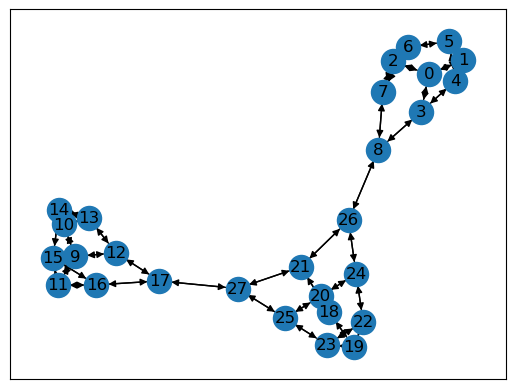

In [217]:
nx.draw_networkx(to_networkx(dataset[0]))

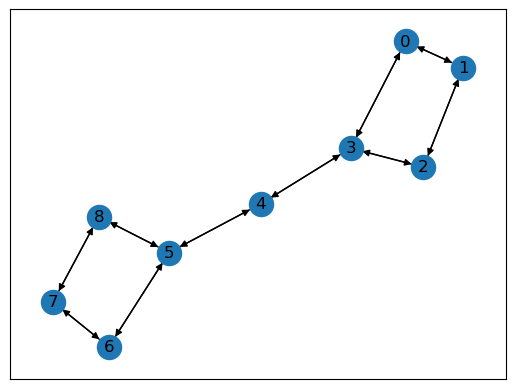

In [190]:
nx.draw_networkx(to_networkx(unique_g[15]))